In [10]:
import matplotlib as mpl
import matplotlib.colors as mcl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import datetime
from datetime import date
import holidays
import warnings

mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='Malgun Gothic')
warnings.filterwarnings('ignore')

# df : DataFrame
# df.index : datetime64 type
# start, end : str('YYYY-MM-DD')
def slicing(df, start, end):
    dateRange = pd.date_range(start, end)
    return df[df['date'].isin(dateRange)]

# df_covid 전처리 (2019-01-01 ~ 2021-07-31)
df_covid = pd.read_csv('./DATA/002_2.COVID-19.csv')
df_covid['DATE']= df_covid['DATE'].astype('str')
df_covid['DATE'] = pd.to_datetime(df_covid['DATE'])
df_covid.rename(columns= {'ID' : 'COUNT'}, inplace=True)
df_covid = df_covid.groupby(['DATE']).count()
df_covid.insert(0, 'date', df_covid.index)
df_covid = df_covid[{'date', 'COUNT'}]

#df_subway 전처리 (2019-01-01 ~ 2021-07-31)
df_subway = pd.read_csv('./DATA/002_1.DAILY_SUBWAY_INFO.csv')
df_subway['date']= df_subway['date'].astype('str')
df_subway['date'] = pd.to_datetime(df_subway['date'])
df_subway = df_subway.drop(['on_num', 'off_num'], axis=1)

# df에 df_subway, df_covid 합치기
df = pd.merge(df_subway, df_covid, how='outer', on='date')
df = df.fillna(0)
df['COUNT'] = df['COUNT'].astype('Int64')
df['total'] = df['total'].astype('Int64')

# df_subway_kor 전처리
df_subway_kor = pd.read_csv('./DATA/002_3.COVID-19_IN_KOREA.csv', thousands = ',')
df_subway_kor = df_subway_kor.iloc[1:].loc[:, ['date', 'total']]
df_subway_kor['date']= df_subway_kor['date'].astype('str')
df_subway_kor['date'] = pd.to_datetime(df_subway_kor['date'])

# df에 df_subway_kor 합치기
df = pd.merge(df, df_subway_kor, how='outer', on='date')
df.columns = ['date', 'subway', 'COVID-19', 'COVID-19 KOR']
df = df.fillna(0)
df['COVID-19 KOR'] = df['COVID-19 KOR'].astype('Int64')

# df_biz : Business day (법정공휴일, 주말 제외)
holidays = holidays.Korea()
datetime.date(2019, 1, 1) in holidays
datetime.date(2020, 1, 1) in holidays
datetime.date(2021, 1, 1) in holidays
df_biz = df[~df['date'].isin(list(holidays.keys()))]
df_biz = df_biz[df_biz['date'].dt.dayofweek < 5].copy()
df_biz = df_biz.set_index('date')
df = df.set_index('date')

# df_week : 주 단위로 묶기 (평균, 합계, 합계)
df_week = pd.DataFrame()
df_week['subway'] = df_biz['subway'].resample('7D').mean()
# df_week['COVID-19'] = df_biz['COVID-19'].resample('7D').sum()
df_week['COVID-19'] = df.drop(df.index[0]).resample('7D').sum()['COVID-19'] ####
df_week['COVID-19 KOR'] = df.drop(df.index[0]).resample('7D').sum()['COVID-19 KOR'] ####

# df_quarter: 분기 단위로 묶기
df_quarter = pd.DataFrame()
df_q_sample = df_biz['2020-01-24':'2021-07-31']
df_q_sample2 = df['2020-01-24':'2021-07-31'] ####

# df_quarter['subway'] = df_q_sample['subway'].resample('1Q').sum()
df_quarter['subway'] = df_q_sample['subway'].resample('1Q').mean() ####
# df_quarter['COVID-19'] = df_q_sample['COVID-19'].resample('1Q').sum()
df_quarter['COVID-19'] = df_q_sample2['COVID-19'].resample('1Q').sum() ####
# df_quarter = df_quarter.astype('float')
df_quarter = df_quarter.reset_index()
df_quarter['date'] = df_quarter['date'].dt.to_period('Q')
# df_quarter.rename(columns= {'date' : 'quarter'}, inplace=True)

#data type을 float로 통일
df = df.astype('float')
df_biz = df_biz.astype('float')
df_week = df_week.astype('float')



df = df.reset_index()
df_biz = df_biz.reset_index()
df_week = df_week.reset_index()

In [11]:
df

,date,subway,COVID-19,COVID-19 KOR
0,2019-01-01,6813453.0,0.0,0.0
1,2019-01-02,15214002.0,0.0,0.0
2,2019-01-03,15716213.0,0.0,0.0
3,2019-01-04,16509281.0,0.0,0.0
4,2019-01-05,12092335.0,0.0,0.0
...,...,...,...,...
975,2021-09-02,0.0,0.0,1961.0
976,2021-09-03,0.0,0.0,1708.0
977,2021-09-04,0.0,0.0,1804.0
978,2021-09-05,0.0,0.0,1490.0


Text(0, 0.5, '지하철 승객')

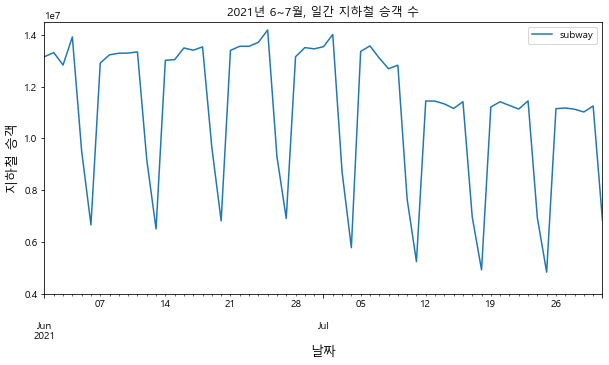

In [14]:
df[882:943].plot(x='date',y='subway', figsize=(10,5), fontsize=10,title='2021년 6~7월, 일간 지하철 승객 수')
plt.ylim(4000000,14500000)
plt.xlabel('날짜', fontsize=13)
plt.ylabel('지하철 승객', fontsize=13)

Text(0, 0.5, '지하철 승객')

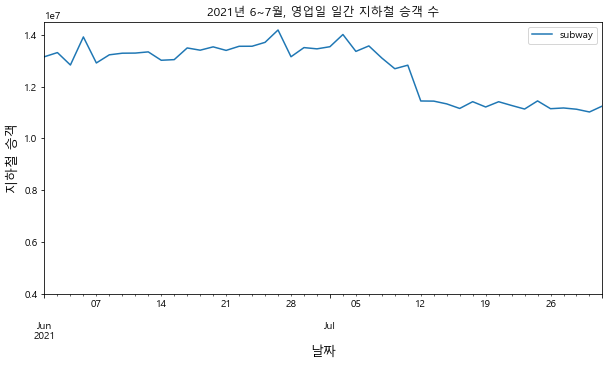

In [16]:
df_biz[598:642].plot(x='date',y='subway', figsize=(10,5), fontsize=10,title='2021년 6~7월, 영업일 일간 지하철 승객 수')
plt.ylim(4000000,14500000)
plt.xlabel('날짜', fontsize=13)
plt.ylabel('지하철 승객', fontsize=13)